# German Traffic Sign Dataset

Third notebook of German Traffic dataset study. In this notebook, I will implement Data preprocessing techniques (Color space conversion, Data balancing, Data augmentation etc.). Also, I will implement more dense network than LeNet architecture and will try to increase the test accuracy.

In [6]:
import keras
import pickle
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
%matplotlib inline

# 1. Load Dataset

In [7]:
# Loading train and test dataset

with open('traffic-signs-data/train.p',mode = 'rb') as f:
    train_data = pickle.load(f)
    
X_train,y_train = train_data['features'],train_data['labels']

with open('traffic-signs-data/valid.p','rb') as ft:
    valid_data = pickle.load(ft)
    
X_valid,y_valid = valid_data['features'],valid_data['labels']

with open('traffic-signs-data/test.p','rb') as ft:
    test_data = pickle.load(ft)
    
X_test,y_test = test_data['features'],test_data['labels']


# 2. Explore Dataset

In [8]:
print (X_train.shape,y_train.shape)
print (X_valid.shape,y_valid.shape)
print (X_test.shape,y_test.shape)

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


In [9]:
number_classes = len(np.unique(y_train))
unique_train, counts_train = np.unique(y_train, return_counts=True)

print ("Number of classes: ", unique_train)
print ()
print ("Counts in each class: ", counts_train)

Number of classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]

Counts in each class:  [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]


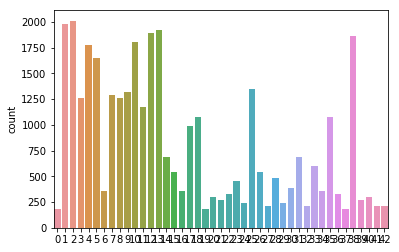

In [10]:
sns.countplot(y_train,label="Count")
plt.show()

## Observations
    1. Dataset has around ~35k train images with 43 classes
    2. From above figure, we can say that dataset is unbalanced with lowest class value 180 and highest 2010. We have to balance these data.
    

## Visulizing train images with labels

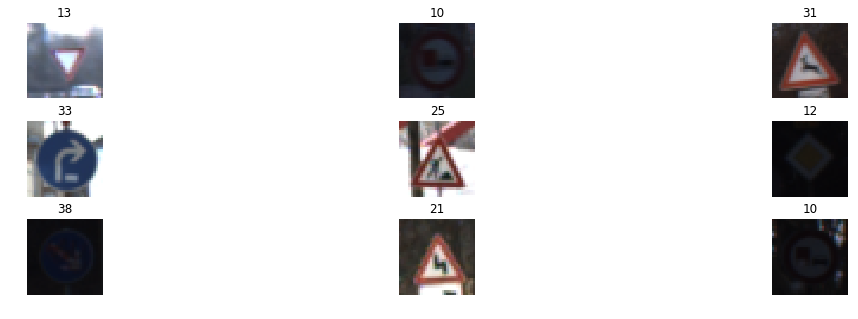

In [11]:
import random
fig,axs = plt.subplots(3,3,figsize=(20,5))
fig.subplots_adjust(hspace = .3,wspace=.005)
axs = axs.ravel()

for i in range(9):
    index = random.randint(0,len(X_train))
    img = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title(y_train[index])

# 3. Data Pre processing

Here we have seen that our data is highly unbalanced, so first we have to balance the dataset. For that, I will **augment** the data. Augmentation can be done with two different approach. First is to use Keras' library ImageDataGenerator class and generate augmentation images on a flow (In-time) so that we load only few images into RAM. Second approach is to create augmented data manually and train the model. Here I am using the first approach. This will increase the training time but it will load less images in a single go into RAM

Second, I will try different color space and decide according to the performance. For now, I have following ideas regarding color space in my mind.
        1. Use RGB as it is.
        2. Use only Grayscale. We can reduce the parameters by using grayscale. Also, for traffic sign classification problem, grayscale images should work good.
        3. RGB + Grayscale images. (Convert RGB to grayscale and then concatenate with RGB channel)
        4. HSV colorspace
        



In [12]:
#Preprocess Data

def normalize_data(data):
    
    normal = data/255.0 - 0.5
    return normal

#Dot method to convert image from RGB to GRAY. Faster method than
#Opencv cvtColor method.
def rgb2gray(data):
    gray = np.dot(data[...,:3],[0.299,0.587,0.114])
    return gray


#Augmented Functions
#CAUTION : The most common augmentation functions are vertical
#and horizontal flips. Both are not useful for our case. 
#We have left turn /right turn images which are mirror images to
#each other. Also we want to read some speed limits so horizontal
#flips are not useful either.

#We can use translation, "MINOR" rotation, Blurring etc.
#Here I am using minor rotation, Affine transformation and Gaussian
#Blurring.

def rotation_minor(img):
    rows,cols,channel = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
    rot = cv2.warpAffine(img,M,(cols,rows))
    return rot

def affine_transform(img):
    rows,cols,channel = img.shape
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pts2 = np.float32([[1,10],[20,5],[10,25]])

    M = cv2.getAffineTransform(pts1,pts2)

    aff = cv2.warpAffine(img,M,(cols,rows))
    return aff

def gaussian_bluring(img):
    gauss_blur = cv2.GaussianBlur(img,(5,5),0)
    return gauss_blur



In [13]:
labelbinarizer = LabelBinarizer()
y_train_one_hot = labelbinarizer.fit_transform(y_train)
y_valid_one_hot = labelbinarizer.fit_transform(y_valid)

print (X_train.shape)
print (X_valid.shape)
print (y_train_one_hot.shape)
print (y_valid_one_hot.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(34799, 43)
(4410, 43)


# 3. Define Model

In [14]:
model = Sequential()

#Layer1
model.add(Conv2D(32,3,padding="same",input_shape=(32,32,3)))
model.add(Activation('relu'))

#Layer2
model.add(Conv2D(32,3,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

#Layer3
model.add(Conv2D(64,3,padding="same"))
model.add(Activation('relu'))

#Layer4
model.add(Conv2D(64,3,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

#Layer5
model.add(Conv2D(128,3,padding="same"))
model.add(Activation('relu'))

#Layer6
model.add(Conv2D(128,3,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
#Flatten
model.add(Flatten())

#FC1
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#FC2
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output
model.add(Dense(number_classes))
model.add(Activation('softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
__________

In [16]:
datagen_new = ImageDataGenerator(featurewise_center = True,
                             featurewise_std_normalization = True,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10.)

In [17]:
datagen_new.fit(X_train)

In [18]:
#model.compile(keras.optimizers.Adam(lr=0.001), 'categorical_crossentropy', ['accuracy'])
model.compile(keras.optimizers.SGD(lr=0.001,decay=1e-6,momentum=0.9), 'categorical_crossentropy', ['accuracy'])


In [19]:
batch_size = 32
epochs = 10
history = model.fit_generator(datagen_new.flow(X_train,y_train_one_hot,
                                           batch_size=batch_size),
                                           steps_per_epoch = X_train.shape[0],
                                           epochs = epochs,
                                           validation_data = (X_valid,y_valid_one_hot))

Epoch 1/10
34799/34799 [==============================] - 2889s 83ms/step - loss: 1.2570 - acc: 0.6053 - val_loss: 0.6300 - val_acc: 0.9546
Epoch 2/10
34799/34799 [==============================] - 3715s 107ms/step - loss: 0.1348 - acc: 0.9595 - val_loss: 0.2974 - val_acc: 0.9785
Epoch 3/10
34799/34799 [==============================] - 3709s 107ms/step - loss: 0.0616 - acc: 0.9824 - val_loss: 0.3291 - val_acc: 0.9782
Epoch 4/10
34799/34799 [==============================] - 2867s 82ms/step - loss: 0.0404 - acc: 0.9886 - val_loss: 0.3096 - val_acc: 0.9798
Epoch 5/10
34799/34799 [==============================] - 2913s 84ms/step - loss: 0.0305 - acc: 0.9915 - val_loss: 0.2853 - val_acc: 0.9812
Epoch 6/10
34799/34799 [==============================] - 2823s 81ms/step - loss: 0.0252 - acc: 0.9930 - val_loss: 0.3032 - val_acc: 0.9805
Epoch 7/10
34799/34799 [==============================] - 2814s 81ms/step - loss: 0.0215 - acc: 0.9941 - val_loss: 0.3001 - val_acc: 0.9800
Epoch 8/10
34799/3

dict_keys(['acc', 'val_acc', 'loss', 'val_loss'])


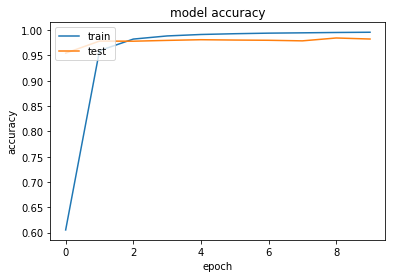

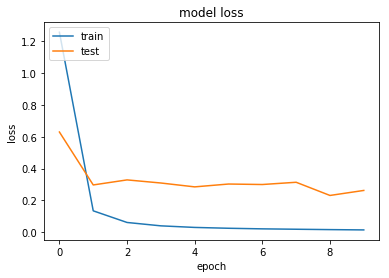

In [20]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.save('German_Traffic_VGGNET_ImageDataGenerator_1.h5')

In [21]:
print (X_test.shape)
print (y_test.shape)
y_test_one_hot = labelbinarizer.fit_transform(y_test)
score, acc = model.evaluate(X_test, y_test_one_hot,
                            batch_size=32)
acc = acc * 100.0
print('Test score:', score)
print('Test accuracy:', acc)

(12630, 32, 32, 3)
(12630,)
12630/12630 [==============================] - 11s 879us/step
Test score: 0.4063400087204353
Test accuracy: 96.98337292633448


# Conclusion

In this notebook, I have implemented LeNet architecture and trained the model on 20 epochs we are getting ~93% accuracy on test data with this setting.

From the above graph it seems that model is overfitting after 12 epochs (Loss is increasing and validation accuracy decreasing)

It seems we need deeper architecture, data augmentation to avoid overfitting and I will try data balancing in next notebook.
